<a href="https://colab.research.google.com/github/GuptaNavdeep1983/CS688/blob/main/Assignment_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#References

 https://www.scikityb.org/en/latest/api/text/index.html

https://cran.r-project.org/web/packages/umap/vignettes/umap.html

https://www.r-bloggers.com/2019/05/quick-and-easy-t-sne-analysis-in-r/

In [5]:
pip install tidytext

In [6]:
pip install pymed

In [7]:
from pymed import PubMed
import pandas as pd
import matplotlib.pyplot as plt
import os.path
from os import path
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import re
import gensim
from gensim import corpora
from gensim.models import LsiModel, LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.test.utils import common_texts
from gensim.parsing.preprocessing import remove_stopwords, strip_punctuation, strip_punctuation2, strip_short, strip_numeric, stem_text
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [8]:
def download_pubmed_results(years, search_text, max_results_count, file_name):
    pubmed = PubMed(tool="PubMedSearcher", email="my@email.address")
    # create dataframe for search results
    df = pd.DataFrame([], columns=['Title', 'Year'])
    # iterate through data frame
    index = 0
    # iterate through years
    for year in years:
        # filter the query by search text and year
        results = pubmed.query(f'({search_text}) AND (("{year}"[Date - Create]))', \
            max_results=max_results_count)
        # iterate through the results as per the query
        for article in results:
            article_dict = article.toDict()
            df.loc[index, "Title"] = article_dict['title']
            df.loc[index, "Year"] = year
            index = index + 1
    # export the results to a CSV
    df.to_csv(file_name, index=False)
def lemmatize_stemming(text):
    stemmer = SnowballStemmer("english")
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

# Tokenize and lemmatize
def preprocess(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
            
    return ' '.join(result)
def create_documents(df):
  documents = []
  for index, row in df.iterrows():
      all_content = preprocess(row['Title'])
      documents.append(all_content)
  return documents

def create_document_term_matrix(documents):
  df = pd.DataFrame(documents, columns=['content'])
  vectorizer = CountVectorizer(input='content',stop_words='english', analyzer='word', token_pattern=r'\b[a-zA-Z]{2,}\b',max_features=100)
  return vectorizer.fit_transform(df['content'])

In [9]:
download_pubmed_results(years=['2020'], search_text='Obesity', max_results_count=100, file_name='obesity_results.csv')
download_pubmed_results(years=['2020'], search_text='Cancer', max_results_count=100, file_name='cancer_results.csv')

In [10]:
df_obesity_results = pd.read_csv("obesity_results.csv")
df_obesity_results.dropna(inplace=True)
df_cancer_results = pd.read_csv("cancer_results.csv")
df_cancer_results.dropna(inplace=True)
final_df = pd.concat([df_obesity_results, df_cancer_results], ignore_index=True)
print(final_df)


                                                 Title  Year
0    Gestational weight gain disparities in South C...  2020
1    Complementary feeding and future health in Mex...  2020
2    Maternal-infant nutrition and development prog...  2020
3    Evaluating the pathways linking complementary ...  2020
4    Intervention during the first 1000 days in Mex...  2020
..                                                 ...   ...
194  Identification of Prognostic Model and Biomark...  2020
195  Integrative Models of Histopathological Image ...  2020
196  Detachment Activated CyPA/CD147 Induces Cancer...  2020
197  Hsa_circ_0088233 Alleviates Proliferation, Mig...  2020
198  HGF/c-Met Axis: The Advanced Development in Di...  2020

[199 rows x 2 columns]


In [11]:
documents = create_documents(final_df)

dtm = create_document_term_matrix(documents)


In [12]:

df_doc_term_matrix = pd.DataFrame(dtm.toarray())

In [13]:
df_doc_term_matrix

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0
195,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
196,1,0,0,0,0,0,0,0,0,1,2,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0
197,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


##PCA

In [14]:
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
ipca = IncrementalPCA(n_components=2)
principalComponents = ipca.fit_transform(df_doc_term_matrix)


In [15]:
principalDf = pd.DataFrame(data = principalComponents, columns = ['PCA1', 'PCA2'])

In [16]:
principalDf['label'] = np.where(principalDf.index > 99, 'cancer', 'obesity')


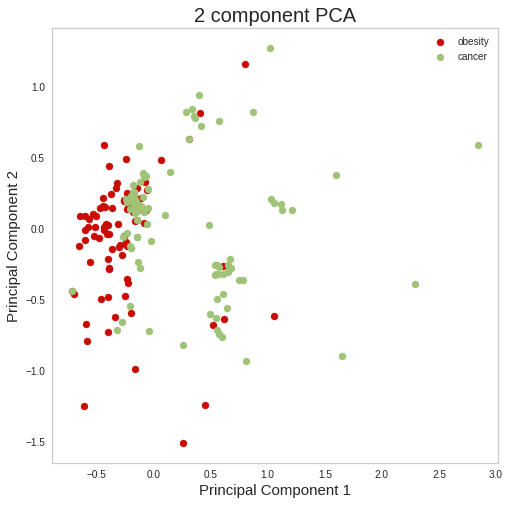

In [17]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['obesity', 'cancer']
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = principalDf['label'] == target
    ax.scatter(principalDf.loc[indicesToKeep, 'PCA1']
               , principalDf.loc[indicesToKeep, 'PCA2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

##t-SNE

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


TSNEVisualizer(alpha=0.7,
               ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fca2f9f7ba8>,
               classes=None, colormap=None, colors=None, decompose=None,
               decompose_by=None, labels=None, random_state=None)

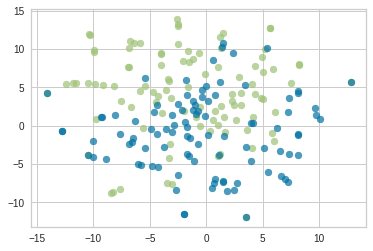

In [20]:
from yellowbrick.text import TSNEVisualizer
from sklearn.feature_extraction.text import TfidfVectorizer

# create document vectors
tfidf = TfidfVectorizer()

X = tfidf.fit_transform(documents)
y = principalDf['label']

tsne = TSNEVisualizer()
tsne.fit(X, y)


##UMAP

In [21]:
pip install git+https://github.com/DistrictDataLabs/yellowbrick.git@develop

  Cloning https://github.com/DistrictDataLabs/yellowbrick.git (to revision develop) to /tmp/pip-req-build-by71hd1j
  Running command git clone -q https://github.com/DistrictDataLabs/yellowbrick.git /tmp/pip-req-build-by71hd1j
  Created wheel for yellowbrick: filename=yellowbrick-1.2-cp36-none-any.whl size=270245 sha256=9a2034b5f00ebae2f682a6187c59501982285efb248ac9160149d7823137b474
  Stored in directory: /tmp/pip-ephem-wheel-cache-nohtm85g/wheels/19/7c/6e/b270407cdf07adc6080f597d76240341462cc12ed477693370
Successfully built yellowbrick


['sports', 'cooking', 'cinema', 'gaming', 'books']


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


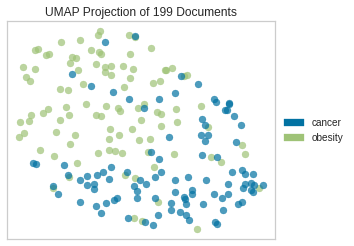

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
from yellowbrick.datasets import load_hobbies
from yellowbrick.text import UMAPVisualizer
# import umap.umap_ as UMAP
tfidf = TfidfVectorizer()
docs = tfidf.fit_transform(documents)
labels = principalDf['label']
corpus = load_hobbies()
print(corpus.labels)
# Instantiate the text visualizer
umap = UMAPVisualizer(metric='cosine')
umap.fit(docs, labels)
umap.show()